<a href="https://colab.research.google.com/github/PigStep/CIFAR-10-based-Content-categorizator/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is this notebook about
This notebook tracks experiments, code and data manipulation for model

# Data loading

In [9]:
import torchvision
import torch
from torchvision.transforms import transforms

In [30]:
batch_size = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.ToTensor()

# Getting CIFAR-10 dataset with batches
trainset = torchvision.datasets.CIFAR10(root="/content",train=True,transform=transform,download=True)
trainloader = torch.utils.data.DataLoader(dataset = trainset,batch_size=batch_size,shuffle=True)

In [11]:
image_tensor, label = trainset[0]

print(f"Shape of tensor: {image_tensor.shape}")
print(f"Label: {label}")

Shape of tensor: torch.Size([3, 32, 32])
Label: 6


## Data normalization

This notebook uses torch's `ToTensor() + Normalize()` functions. Firstly we need to get some statistics before Normalization

In [12]:
channels_sum, channels_squared_sum, num_pixels = 0,0,0

for images, _ in trainloader:
  # images: [batch_size, channels, height, width]

  channels_sum += torch.sum(images, dim=[0,2,3])
  channels_squared_sum += torch.sum(images**2, dim = [0,2,3])
  num_pixels += images.numel()

mean = channels_sum / num_pixels
# std = sqrt(E[x^2] - (E[x])^2)
std = torch.sqrt((channels_squared_sum / num_pixels) - mean**2)

print(f"Channels means: {mean}")
print(f"Channels std: {std}")

Channels means: tensor([0.1638, 0.1607, 0.1488])
Channels std: tensor([0.2720, 0.2673, 0.2591])


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

# Getting datasets with normalization
trainset = torchvision.datasets.CIFAR10(root="/content",train=True,transform=transform,download=True)

testset = torchvision.datasets.CIFAR10(root="/content",train=False,transform=transform,download=True)
testloader = torch.utils.data.DataLoader(dataset = testset,batch_size=batch_size,shuffle=True)

# Model development

## Baseline model: self constructed pytorch CNN

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class baseCNN(nn.Module):
  def __init__(self):
    super().__init__()

    # 32x32 3 channels
    self.conv1 = nn.Conv2d(3, 32, 3)
    # 30x30 32 channels
    self.pool1 = nn.MaxPool2d(2,2)
    # 15x15 32 channels
    self.conv2 = nn.Conv2d(32, 64, 3)
    # 13x13 64 channels
    self.pool2 = nn.MaxPool2d(2,2)
    #6х6 64 channels
    self.fc = nn.Linear(2304,10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = torch.flatten(x,1)
    x = self.fc(x)

    return x


In [18]:
def train(baseCNN, train_loader, lr = 0.001, epochs = 100, thread_err = 0.01):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(baseCNN.parameters(), lr=lr)
    loss_list = []
    last_loss = 0

    for epoch in range(epochs):
      total_loss = 0
      for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()

        prediction = baseCNN.forward(image)
        error = loss_fn(prediction, label)

        total_loss += error.item()

        error.backward()

        optimizer.step()

      avg_loss = total_loss / len(train_loader)
      loss_list.append(avg_loss)
      print(f"Epoch: {epoch}, Error: {avg_loss}")

      if(abs(last_loss - avg_loss) < thread_err):
          return loss_list

      last_loss = avg_loss

    print("Training finished")
    return loss_list

In [19]:
CNN = baseCNN()
losses = train(CNN, trainloader)

Epoch: 0, Error: 1.7532110293300784
Epoch: 1, Error: 1.4492747807989315
Epoch: 2, Error: 1.3298904695072953
Epoch: 3, Error: 1.268771966501158
Epoch: 4, Error: 1.207630206127556
Epoch: 5, Error: 1.1643628027974342
Epoch: 6, Error: 1.1240769256742633
Epoch: 7, Error: 1.0871823195900236
Epoch: 8, Error: 1.0629975926511142
Epoch: 9, Error: 1.0374691145760673
Epoch: 10, Error: 1.0126859831566712
Epoch: 11, Error: 0.9904705757389263
Epoch: 12, Error: 0.9723065157934111
Epoch: 13, Error: 0.9540976593080832
Epoch: 14, Error: 0.9437995002586015
Epoch: 15, Error: 0.9269688649445164
Epoch: 16, Error: 0.9100234523719671
Epoch: 17, Error: 0.8955729698040047
Epoch: 18, Error: 0.8861212447589758


Text(0, 0.5, 'Error')

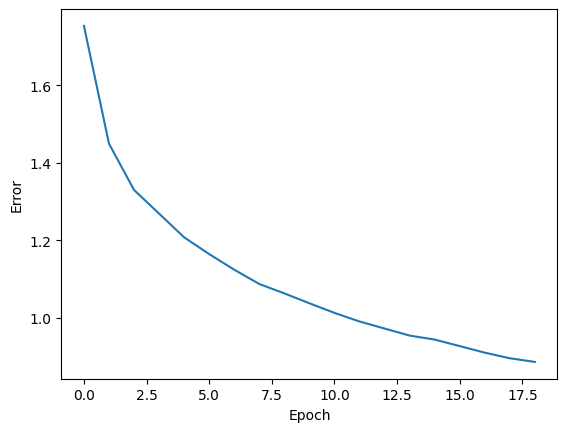

In [84]:
# vizualize losses
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Error")

In [94]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import numpy as np

def get_classification_metrics(model, test_loader):
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for image, label in test_loader:
      image, label = image.to(device), label.to(device)
      prediction = model.forward(image)
      # Get predicted class labels by finding the index of the maximum value in the prediction tensor
      predicted_labels = torch.argmax(prediction, dim=1)
      all_preds.append(predicted_labels)
      all_labels.append(label)

  # Concatenate all predictions and labels
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)

  matrix=confusion_matrix(all_labels, all_preds)
  accuracy = accuracy_score(all_labels, all_preds)
  f1_score_macro = f1_score(all_labels, all_preds, average='macro')
  precision = precision_score(all_labels, all_preds, average='macro')
  recall = recall_score(all_labels, all_preds, average='macro')

  return matrix, accuracy, f1_score_macro, precision, recall

In [95]:
matrix, accuracy, f1_score_macro, precision, recall = get_classification_metrics(CNN, testloader)

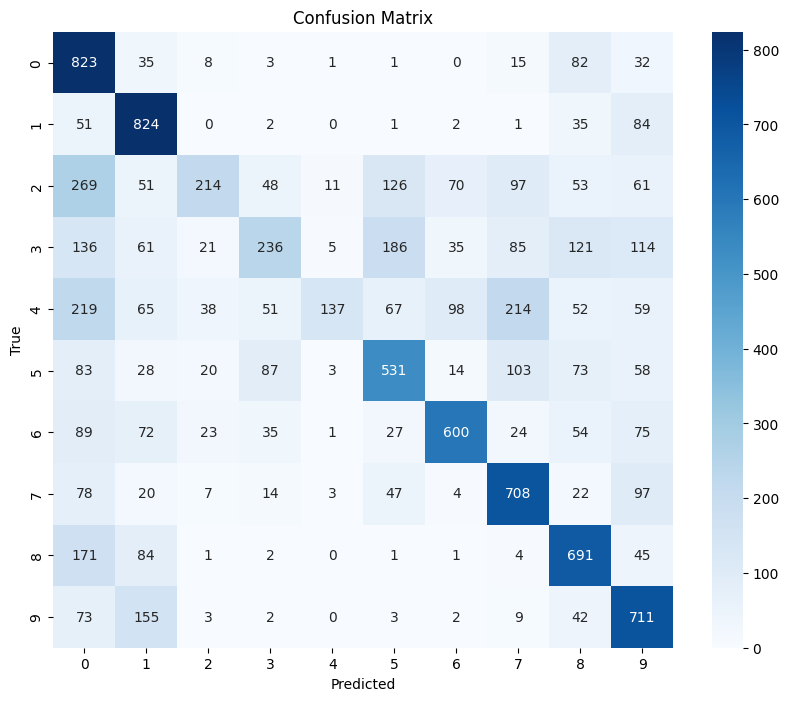

In [98]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('/content/confusion_matrix.png')
plt.show()

Get metrics from model and track them using `mlflow`

In [ ]:
%pip install -q dagshub 'mlflow>=2,<3'

In [109]:
import dagshub
import mlflow

dagshub.init(repo_owner='PigStep', repo_name='CIFAR-10-based-Content-categorizator', mlflow=True)

with mlflow.start_run():
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1_score_macro', f1_score_macro)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)

    mlflow.log_param('batch_size', 256)
    mlflow.log_param('learning_rate', 0.001)
    mlflow.log_param('epochs', 100)
    mlflow.log_param('thread_err', 0.01)
    mlflow.log_param('optimizer','Adam')

    mlflow.log_artifact('confusion_matrix.png')

    mlflow.pytorch.log_model(CNN, "baseline CNN model")

Initialized MLflow to track repo "PigStep/CIFAR-10-based-Content-categorizator"

Repository PigStep/CIFAR-10-based-Content-categorizator initialized!

RestException: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}